# Text generation metrics comparison

In [1]:
import pandas as pd
import numpy as np
from zenml.client import Client
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy
from scipy.stats import mannwhitneyu, wilcoxon


plt.style.use("ggplot")

In [2]:
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_colwidth", 30)
 
from github_search.pipelines.get_zenml_results import ArtifactLoader

In [3]:
artifact.step.name

'evaluate_generated_texts'

In [4]:
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_colwidth", 30)

#p = list(P("../data").rglob("*.jsonl"))[0]
#evaluated_df = pd.read_json(p, orient="records", lines=True).set_index("repo", drop=True)
artifact = Client().get_artifact('8eb34559-0386-4f39-aa0a-8ef4ad1a0373')
loaded_artifact = artifact.load()
evaluated_df = artifact.load()
evaluated_df = evaluated_df.rename(columns={"f1": "bertscore_f1", "recall": "bertscore_recall", "precision": "bertscore_precision"})

In [5]:
evaluated_df

,repo,tasks_x,true_tasks,generated_text,prompt_info,...,rouge1,rouge2,rougeL,rougeLsum,sentence_transformer_similarity
66,nikolamilosevic86/TabInOut,semantic information retri...,"information retrieval, tab...",information retrieval came...,{'content': 'AnalyzePatter...,...,0.500000,0.333333,0.500000,0.500000,0.564342
68,nikolamilosevic86/TabInOut,"data collection, SARS-CoV-...","information retrieval, tab...",information retrieval came...,{'content': 'AnalyzePatter...,...,0.500000,0.333333,0.500000,0.500000,0.564342
67,nikolamilosevic86/TabInOut,"data extraction, security,","information retrieval, tab...",information retrieval came...,{'content': 'AnalyzePatter...,...,0.500000,0.333333,0.500000,0.500000,0.564342
201,JLrumberger/SpatialEmbeddi...,"semantic segmentation, unt...","semantic segmentation, aut...",lesion segmentation semant...,{'content': 'embedding_los...,...,0.461538,0.181818,0.461538,0.461538,0.599269
203,JLrumberger/SpatialEmbeddi...,"computer vision, spatial c...","semantic segmentation, aut...",lesion segmentation semant...,{'content': 'embedding_los...,...,0.461538,0.181818,0.461538,0.461538,0.599269
...,...,...,...,...,...,...,...,...,...,...,...
4,gongzhitaao/adversarial-cl...,"wildfire fighting, jcw:fac...",adversarial attack,stereo lidar fusion,{'content': 'src/figure_2....,...,0.000000,0.000000,0.000000,0.000000,0.221169
1,Ohraincu/JDNet,real-time single image sup...,"rain removal, single image...",weather forecasting,{'content': 'code/ablation...,...,0.000000,0.000000,0.000000,0.000000,0.308940
297,da03/Attention-OCR,"OCR, model, recurrent model,",optical character recognition,data augmentation,{'content': 'src/exp_confi...,...,0.000000,0.000000,0.000000,0.000000,0.175826
294,masoudpz/AVID-Adversarial-...,"adversarial learning, imag...",anomaly detection,molecular property prediction,{'content': 'fake_data_loa...,...,0.000000,0.000000,0.000000,0.000000,0.377542


In [6]:
evaluated_df["generated_length"] = evaluated_df["generated_text"].str.split().apply(len)
evaluated_df["length"] = evaluated_df["true_tasks"].str.split().apply(len)
evaluated_df["edit_word"] = 1 / evaluated_df["edit_word"]

In [7]:
generation_metrics_df = evaluated_df.select_dtypes("float").groupby(evaluated_df["repo"]).agg("mean")

Used sampling: small (100 examples, for each repo tasks were generated 3 times)

## Comments

- starcoderbase-7b was used for generation
- all metrics have same monotonicity ("more is better")
- the correlations are Spearman's rho because using Pearson's correlation would be problematic
- sentence transformer similarity uses "paraphrase-distilroberta-base-v1", the score is cosine similarity of embeddings
- interestingly bertscore and sentence transformer score have different behavior with respect to text length

### Conclusion

We choose sentence_transformer_similarity, bertscore_f1 and rouge2 as they are representative of their clearly visible groups which are not correlated across other groups

<Axes: >

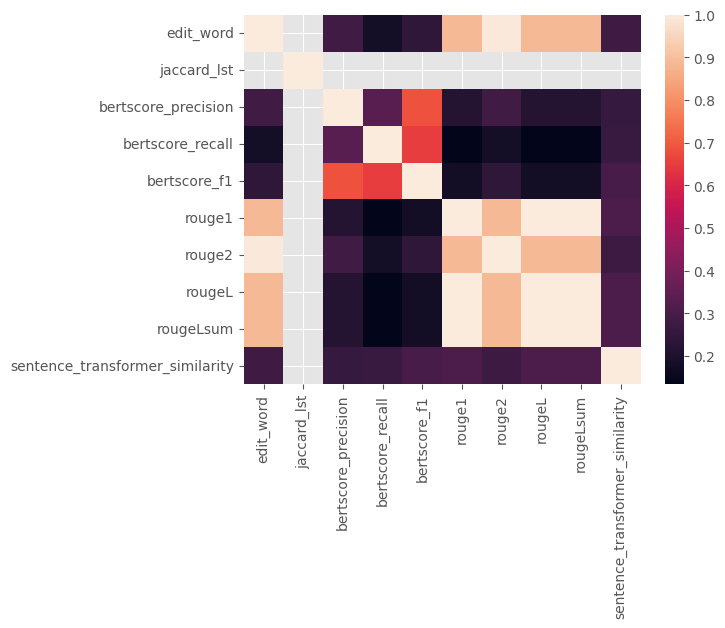

In [8]:
sns.heatmap(generation_metrics_df.corr(method="kendall"))

<Axes: xlabel='length', ylabel='bertscore_f1'>

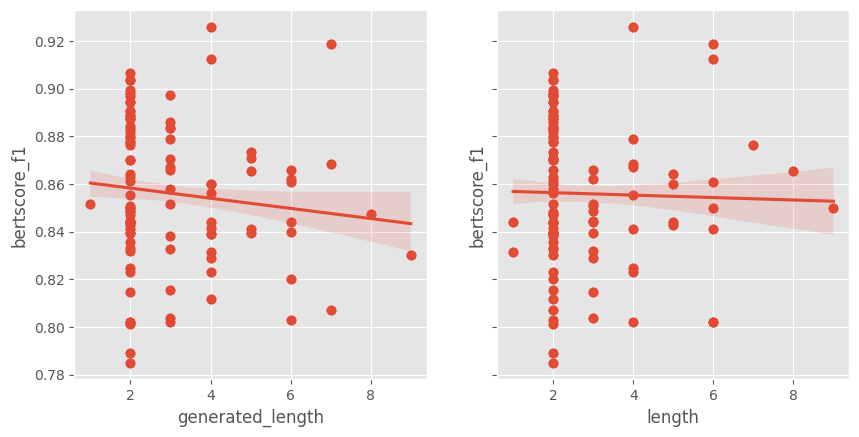

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_figwidth(10)

sns.regplot(evaluated_df, x="generated_length", y="bertscore_f1", ax=ax1)
sns.regplot(evaluated_df, x="length", y="bertscore_f1", ax=ax2)

<Axes: xlabel='length', ylabel='sentence_transformer_similarity'>

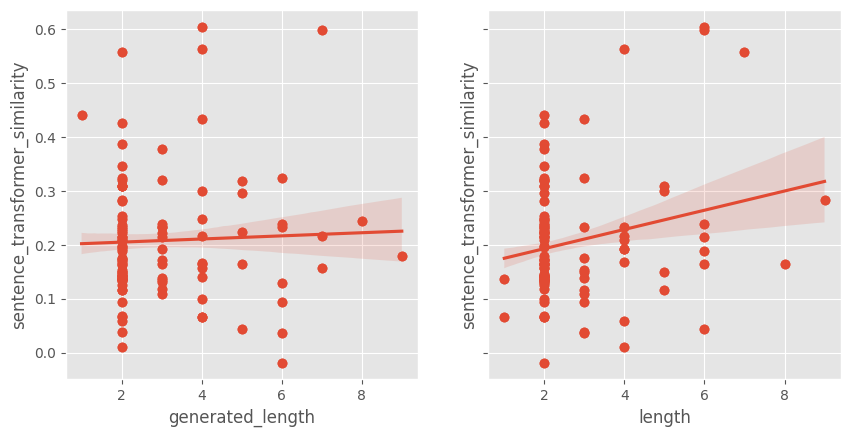

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_figwidth(10)

sns.regplot(evaluated_df, x="generated_length", y="sentence_transformer_similarity", ax=ax1)
sns.regplot(evaluated_df, x="length", y="sentence_transformer_similarity", ax=ax2)

## IR vs generation metrics

Used sampling: no_sampling

In [12]:
client = Client()

In [13]:
#artifact = Client().get_artifact('01a912a3-66f1-4ea4-b549-05d1d01441f8')
#generated_texts_df = artifact.load()


In [14]:
#generated_texts_df.head()

In [15]:
def clip_inf(df, col):
    m = df.loc[df[col] != np.inf, col].max()
    df[col] = df[col].replace(np.inf ,m)
    return df

In [16]:
#artifact = Client().get_artifact('b7c725a8-3efa-459e-94c9-160793c89024')
artifact = Client().get_artifact('ba553891-6a9c-4457-a739-065a1ae6d037')
generation_metrics_df = clip_inf(artifact.load(), "wmd")

In [17]:
artifact.step.name

'evaluate_generation'

In [18]:
generation_metrics_df.columns

Index(['repo', 'tasks', 'true_tasks', 'generated_text', 'prompt_info',
       'generation', 'input_text', 'reference_text', 'bertscore_precision',
       'bertscore_recall', 'bertscore_f1', 'hashcode', 'rouge1', 'rouge2',
       'rougeL', 'rougeLsum', 'wmd', 'sentence_transformer_similarity'],
      dtype='object')

In [19]:
#artifact = Client().get_artifact('e21141cd-92b5-4c28-9cf8-5865d7f21582'

OLD_RUN_ID = '53476d74-db41-4152-acf7-41c04af96c4f'
NEW_RUN_ID = '8fcc105d-f7eb-45a8-8284-c509200b0d7d'
artifact = Client().get_artifact(NEW_RUN_ID)

all_experiments_metrics_results = artifact.load()
metrics_results = all_experiments_metrics_results[0]

In [20]:
metrics_results.ir_config.column_config

InformationRetrievalColumnConfig(document_cols=('dependencies', 'tasks'), query_col='true_tasks', list_cols=())

In [21]:
import pprint
n_runs = len(metrics_results.generation_metrics)

In [22]:
metrics_results.dict().keys()

dict_keys(['ir_config', 'per_query_metrics', 'aggregate_metrics', 'generation_metrics'])

In [23]:
pd.DataFrame.from_records(metrics_results.generation_metrics[0])

,repo,tasks,true_tasks,generated_text,prompt_info,...,rouge2,rougeL,rougeLsum,wmd,sentence_transformer_similarity
0,karlgodin/DP10-hockey-pose...,"pose estimation,",[pose estimation],"pose estimation,",{'content': 'SuperRNModel....,...,1.0,1.0,1.0,0.000000,0.922842
1,qilei123/RefineDet4OpenIma...,"object detection,",[object detection],"object detection,",{'content': 'data/VOC0712/...,...,1.0,1.0,1.0,0.000000,0.911541
2,tufts-ml/GAN-Ensemble-for-...,"anomaly detection,",[anomaly detection],"anomaly detection,",{'content': 'dataloader/kd...,...,1.0,1.0,1.0,0.000000,0.948127
3,nsom/ssd,"object detection,",[object detection],"object detection,","{'content': 'ssd_eval.py, ...",...,1.0,1.0,1.0,0.000000,0.911541
4,freedbee/continual_regular...,"continual learning,",[continual learning],"continual learning,",{'content': 'CIFAR/scatter...,...,1.0,1.0,1.0,0.000000,0.956008
...,...,...,...,...,...,...,...,...,...,...,...
34242,brain-research/mirage-rl,general dependency injecti...,"[policy gradient methods, ...",general dependency injecti...,"{'content': 'lqg/lqr.py, l...",...,0.0,0.0,0.0,1.094166,0.178669
34243,ja-che/hidimstat,single subject-level analy...,[eeg],single subject-level analy...,{'content': 'examples/plot...,...,0.0,0.0,0.0,1.418060,-0.019339
34244,kh12lee/kh_lee,"style transfer, neural sty...",[image generation],"style transfer, neural sty...","{'content': 'ppl.py, calc_...",...,0.0,0.0,0.0,1.085241,0.187261
34245,dragonfly/dragonfly,multi-objective optimizati...,[bayesian optimisation],multi-objective optimizati...,{'content': 'bin/dragonfly...,...,0.0,0.0,0.0,0.956154,0.400155


In [24]:
pd.DataFrame(metrics_results.aggregate_metrics[1]).describe()

,accuracy@1,accuracy@3,accuracy@5,accuracy@10,hits@1,...,recall@5,recall@10,MRR@10,ndcg@10,AveP@50
count,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,...,1238.000000,1238.000000,1238.000000,1238.00000,1238.000000
mean,0.215670,0.327141,0.403069,0.487076,0.215670,...,0.012919,0.021283,0.292815,0.18049,0.060270
std,0.411453,0.469359,0.490713,0.500035,0.411453,...,0.035214,0.049632,0.396683,0.25466,0.118129
min,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.008000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.008000,0.020000,0.500000,0.30450,0.064000
max,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.444000,0.667000,1.000000,1.00000,0.909000


In [25]:
metrics_results.dict().keys()

dict_keys(['ir_config', 'per_query_metrics', 'aggregate_metrics', 'generation_metrics'])

In [26]:
n_runs

3

In [27]:
run_generation_metrics_dfs = [pd.DataFrame(metrics_results.generation_metrics[i]) for i in range(n_runs)]
all_generation_metrics_df = pd.concat(run_generation_metrics_dfs)

In [28]:
run_per_query_ir_metrics_dfs =  [pd.DataFrame(metrics_results.per_query_metrics[i]).set_index("query").assign(generation=i) for i in range(n_runs)]
per_query_ir_metrics_df = pd.concat(run_per_query_ir_metrics_dfs)

In [29]:
per_query_ir_metrics_df.groupby(per_query_ir_metrics_df.index).agg("mean")

,accuracy@1,accuracy@3,accuracy@5,accuracy@10,hits@1,...,recall@10,MRR@10,ndcg@10,AveP@50,generation
query,,,,,,,,,,,
,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,1.0
2d human pose estimation,0.0,1.0,1.0,1.0,0.0,...,0.016,0.333,0.430,0.209,1.0
2d object detection,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,1.0
2d semantic segmentation,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,1.0
3d absolute human pose estimation,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.003,1.0
...,...,...,...,...,...,...,...,...,...,...,...
zero shot learning,0.0,1.0,1.0,1.0,0.0,...,0.004,0.500,0.234,0.055,1.0
zero shot object detection,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,1.0
zero shot text search,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,1.0


In [30]:
exploded_generation_metrics_df = (
    all_generation_metrics_df
    .explode("true_tasks").rename(columns={"true_tasks": "query"})
)
exploded_generation_metrics_df = clip_inf(exploded_generation_metrics_df, "wmd")

def positive_hmean(scores):
    return scipy.stats.hmean(np.maximum(0, scores))



In [31]:
def aggregate_per_query_metrics(run_generation_metrics_df, run_ir_metrics_df):
    exploded_generation_metrics_df = (
    run_generation_metrics_df
        .explode("true_tasks").rename(columns={"true_tasks": "query"})
    )
    exploded_generation_metrics_df = clip_inf(exploded_generation_metrics_df, "wmd")

    per_query_generation_metrics_df = (
        exploded_generation_metrics_df
        .select_dtypes("number")
        .groupby(exploded_generation_metrics_df["query"])
        .agg("mean")
    )

    per_query_metrics_df = per_query_generation_metrics_df.merge(run_ir_metrics_df.groupby("query").agg("mean"), left_index=True, right_index=True)
    return per_query_metrics_df

def get_per_query_metrics_df(metrics_results):
    run_generation_metrics_dfs = [pd.DataFrame(metrics_results.generation_metrics[i]) for i in range(n_runs)]
    all_generation_metrics_df = pd.concat(run_generation_metrics_dfs)
    run_per_query_ir_metrics_dfs =  [pd.DataFrame(metrics_results.per_query_metrics[i]).set_index("query").assign(generation=i) for i in range(n_runs)]
    per_query_ir_metrics_df = pd.concat(run_per_query_ir_metrics_dfs)
    return aggregate_per_query_metrics(all_generation_metrics_df, per_query_ir_metrics_df)

In [32]:

ir_metric_names = per_query_ir_metrics_df.select_dtypes("number").columns
generation_metric_names = exploded_generation_metrics_df.select_dtypes(include="number").columns

In [33]:
per_query_metrics_df = get_per_query_metrics_df(metrics_results)

In [34]:
per_query_metrics_df

,generation_x,bertscore_precision,bertscore_recall,bertscore_f1,rouge1,...,recall@10,MRR@10,ndcg@10,AveP@50,generation_y
query,,,,,,,,,,,
,1.0,0.738501,0.723219,0.730207,0.121001,...,0.000,0.000,0.000,0.000,1.0
2d human pose estimation,1.0,0.872205,0.836919,0.853910,0.170146,...,0.016,0.333,0.430,0.209,1.0
2d object detection,1.0,0.858884,0.835993,0.847011,0.135441,...,0.000,0.000,0.000,0.000,1.0
2d semantic segmentation,1.0,0.855642,0.842202,0.848766,0.130055,...,0.000,0.000,0.000,0.000,1.0
3d absolute human pose estimation,1.0,0.878776,0.848565,0.863281,0.233132,...,0.000,0.000,0.000,0.003,1.0
...,...,...,...,...,...,...,...,...,...,...,...
zero shot learning,1.0,0.854723,0.838216,0.846179,0.105151,...,0.004,0.500,0.234,0.055,1.0
zero shot object detection,1.0,0.860634,0.854251,0.857203,0.202309,...,0.000,0.000,0.000,0.000,1.0
zero shot text search,1.0,0.847703,0.817910,0.832409,0.147222,...,0.000,0.000,0.000,0.000,1.0


In [35]:
ir_metric_names = ["accuracy@10", "hits@10", "MRR@10"]
generation_metric_names = ["wmd", "bertscore_f1", "rougeL", "sentence_transformer_similarity"]

In [36]:
def get_corr_df(per_query_metrics_df, ir_metric_names, generation_metric_names, method="spearman"):
    return per_query_metrics_df.corr(method="spearman").loc[
        ir_metric_names, generation_metric_names
    ]
    
def get_df_complement(df_subset, df):
    return df[~pd.Series(df.index).isin(df_subset.index).values]


def complement_mannwhitney(df_subset, df, metric):
    complement_df = get_df_complement(df_subset, df)
    return mannwhitneyu(df_subset[metric], complement_df[metric])

In [37]:
ir_vs_generation_metrics_df = get_corr_df(per_query_metrics_df, ir_metric_names, generation_metric_names)

In [38]:
def show_col_pairplots(df, ref_col, cols):
    fig, axes = plt.subplots(ncols=len(cols), sharey=True)
    fig.set_figwidth(15)
    for (col, ax) in zip(cols, axes):
        sns.regplot(df, x=ref_col, y=col, ax=ax)

def show_pairplots(df, ref_cols, cols):
    for col in ref_cols:
        show_col_pairplots(df, col, cols)

In [39]:
per_query_metrics_df["accuracy@10"]

query
                                           0.0
2d human pose estimation                   1.0
2d object detection                        0.0
2d semantic segmentation                   0.0
3d absolute human pose estimation          0.0
                                          ... 
zero shot learning                         1.0
zero shot object detection                 0.0
zero shot text search                      0.0
zero shot text to image generation         0.0
zero shot transfer image classification    0.0
Name: accuracy@10, Length: 1238, dtype: float64

## Displaying results

## Generation metrics 

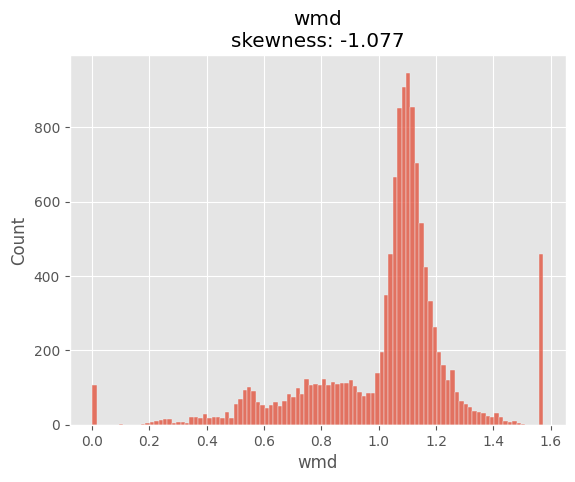

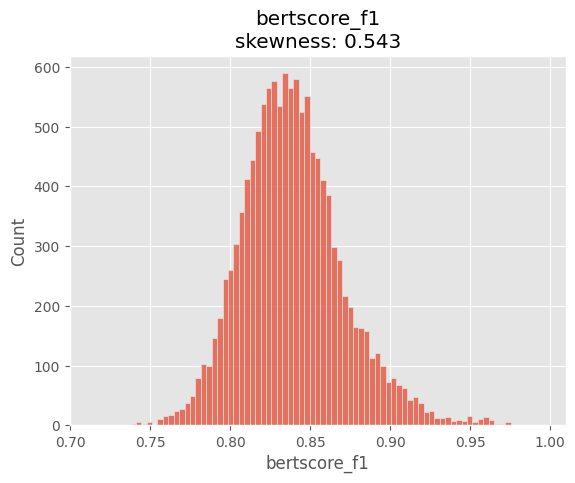

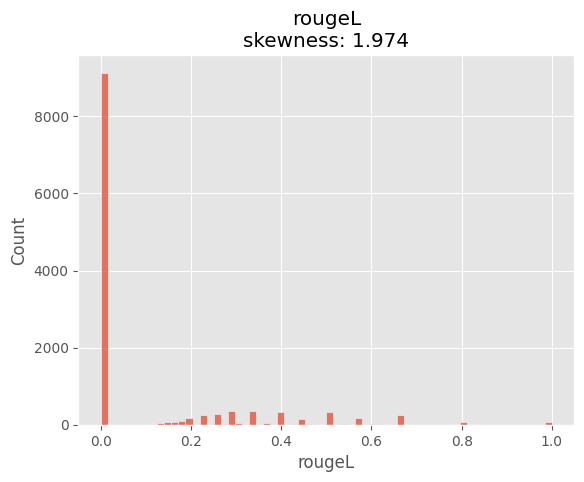

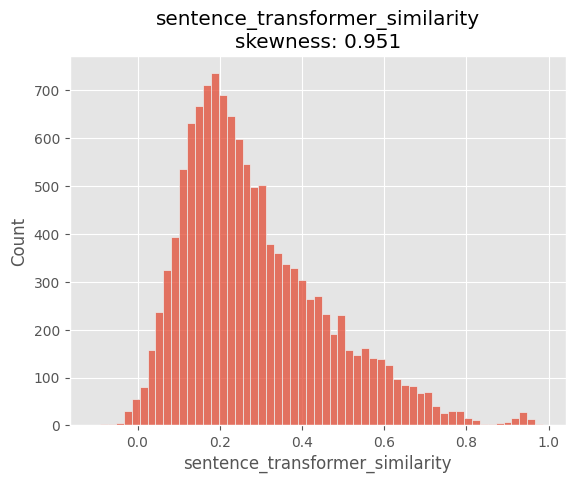

In [40]:
for col in generation_metric_names:
    skewness = scipy.stats.skew(generation_metrics_df[col])
    plt.title(f"{col}\nskewness: {round(skewness, 3)}") 
    sns.histplot(generation_metrics_df[col])
    plt.savefig(f"../results/generation_metrics/{col}.png")
    plt.show()

## Per query metrics

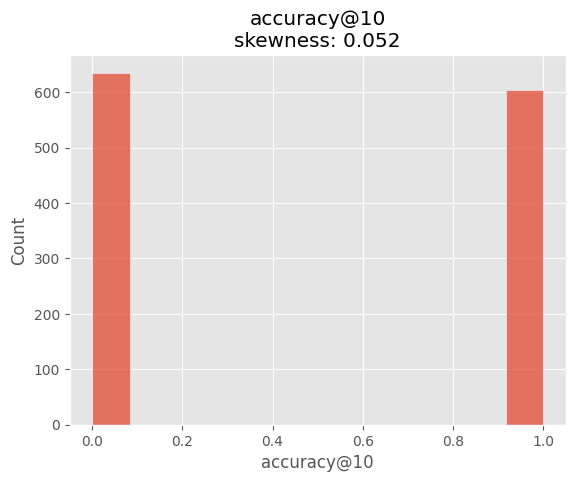

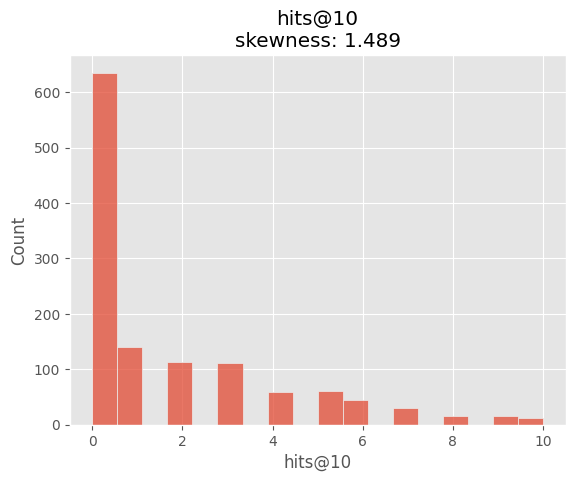

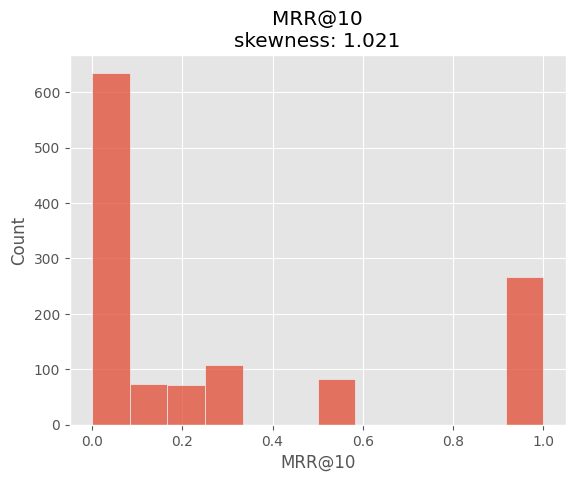

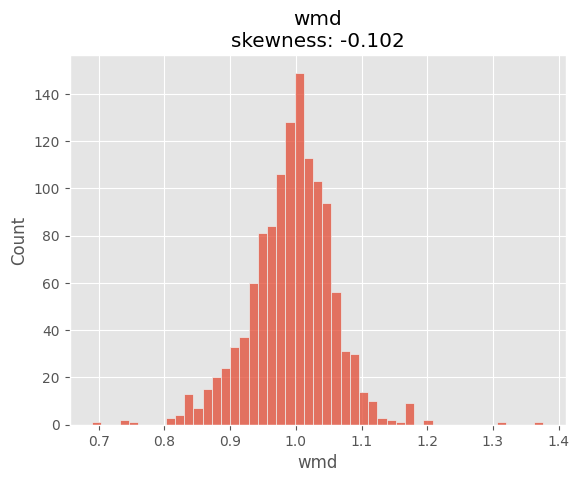

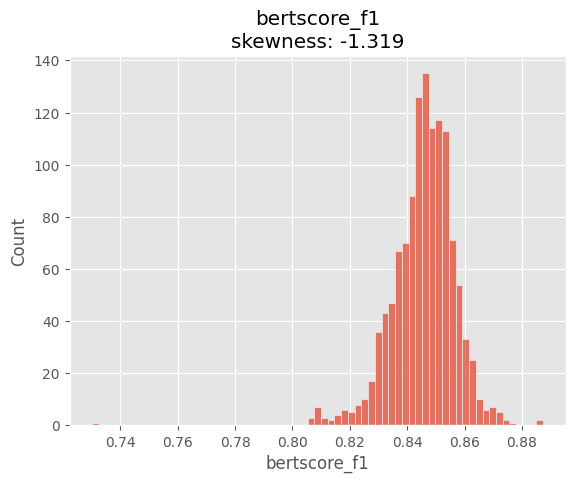

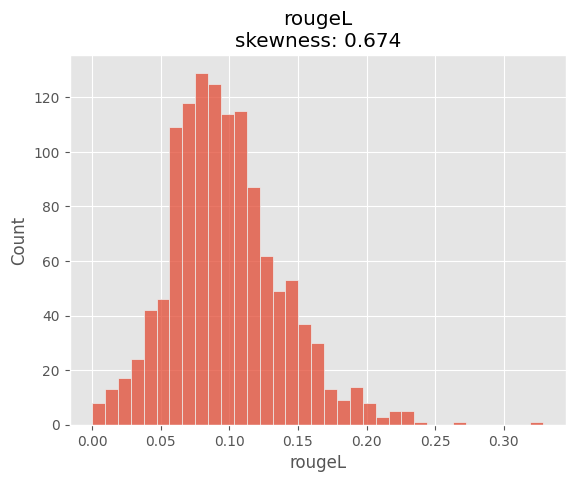

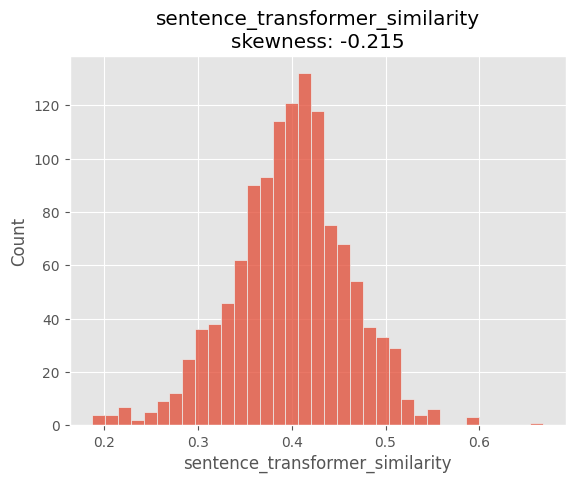

In [41]:
for col in ir_metric_names + generation_metric_names:
    skewness = scipy.stats.skew(per_query_metrics_df[col])
    plt.title(f"{col}\nskewness: {round(skewness, 3)}") 
    sns.histplot(per_query_metrics_df[col])
    plt.savefig(f"../results/per_query_metrics/{col}.png")
    plt.show()

,accuracy@10,hits@10,MRR@10
count,1238.000000,1238.000000,1238.000000
mean,0.487076,1.702746,0.292815
std,0.500035,2.387757,0.396683
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,3.000000,0.500000
max,1.000000,10.000000,1.000000


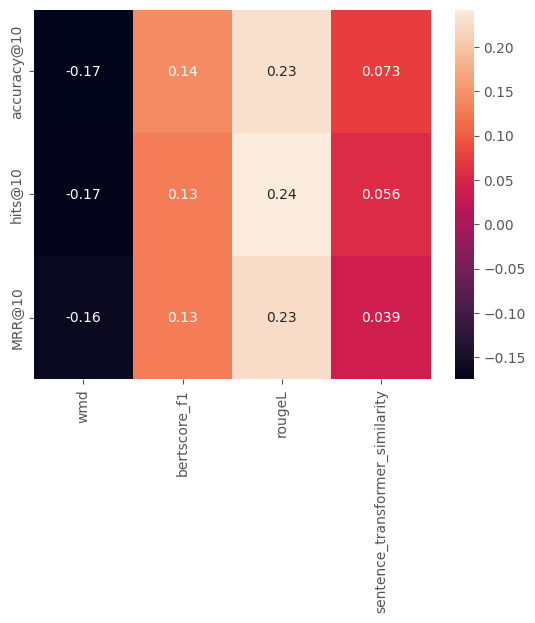

In [42]:
sns.heatmap(ir_vs_generation_metrics_df, annot=True)
plt.savefig("../results/ir_vs_generation_heatmap.png")
per_query_metrics_df[ir_metric_names].describe().round(2).to_csv("../results/per_query_ir_metrics.csv")
per_query_metrics_df[ir_metric_names].describe()

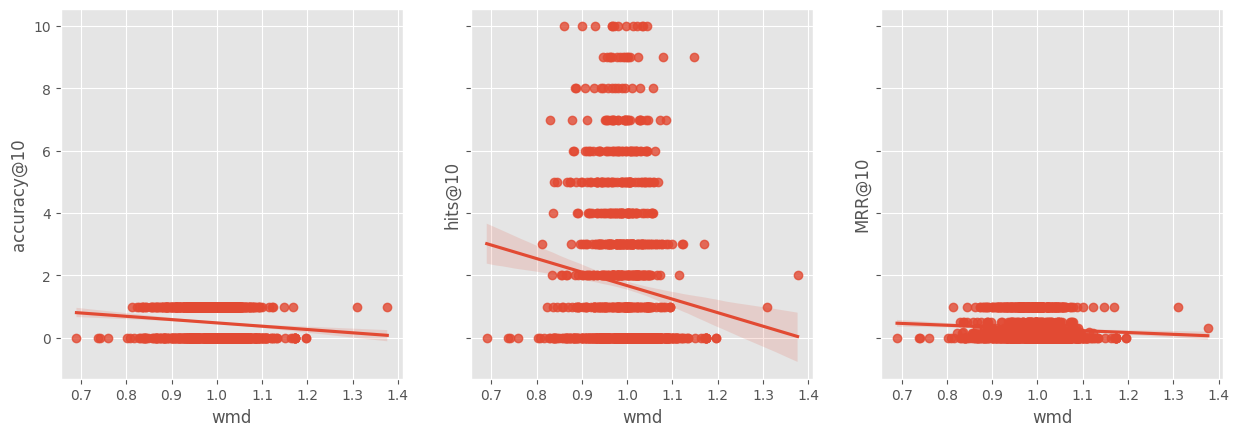

In [43]:
show_col_pairplots(per_query_metrics_df, "wmd", ir_metric_names)
plt.savefig("../results/pairplots/wmd_vs_ir.png")

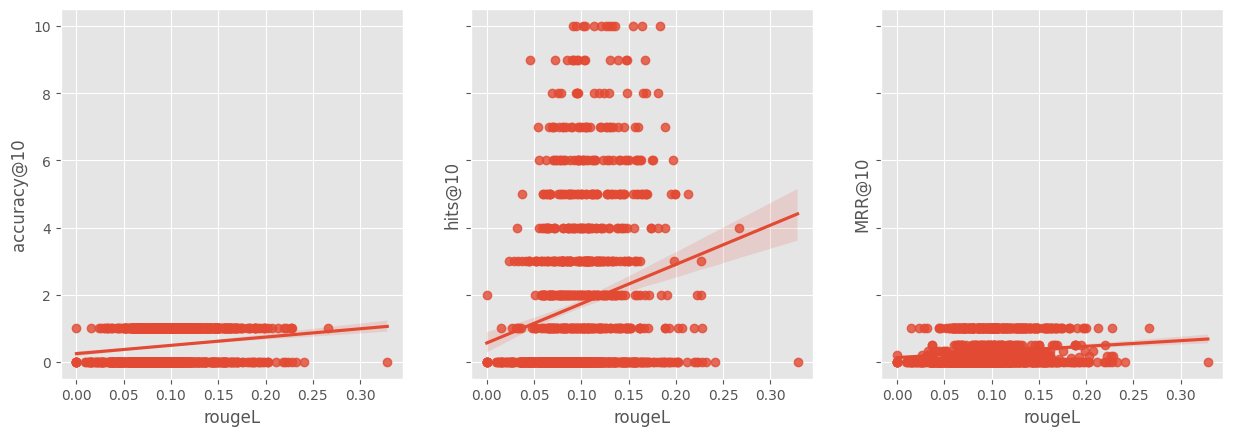

In [44]:
show_col_pairplots(per_query_metrics_df, "rougeL", ir_metric_names)
plt.savefig("../results/pairplots/rouge_vs_ir.png")

In [45]:
def select_extremal_queries_by_metric(per_query_metrics_df, metric_name, q=0.1, bottom=True):
    metric_quantile = per_query_metrics_df[metric_name].quantile(q)
    if bottom:
        condition = per_query_metrics_df[metric_name] <= metric_quantile
    else:
        condition = per_query_metrics_df[metric_name] >= metric_quantile
    return  per_query_metrics_df[condition]

## Impact of generation metrics on information retrieval metrics

In [76]:
per_query_metrics_df.index

Index(['', '2d human pose estimation', '2d object detection',
       '2d semantic segmentation', '3d absolute human pose estimation',
       '3d action recognition', '3d aware image synthesis',
       '3d classification', '3d depth estimation', '3d face alignment',
       ...
       'word translation', 'zero shot action recognition',
       'zero shot cross lingual transfer', 'zero shot cross modal retrieval',
       'zero shot image classification', 'zero shot learning',
       'zero shot object detection', 'zero shot text search',
       'zero shot text to image generation',
       'zero shot transfer image classification'],
      dtype='object', name='query', length=1238)

In [102]:
generation_metric_names

['wmd', 'bertscore_f1', 'rougeL', 'sentence_transformer_similarity']

In [201]:
metric_comparison_df = per_query_metrics_df.drop(columns=["generation_x", "generation_y"])
for metric_name in generation_metric_names:
    metric_comparison_df[metric_name] = pd.qcut(causal_df[metric_name], 10, labels=False)

In [204]:
((metric_comparison_df[col] > i) * 1).dtype

dtype('int64')

In [214]:
ir_vs_generation_quantiles_df = pd.DataFrame()
for col in generation_metric_names:
    ir_vs_generation_quantiles_df[col] = metric_comparison_df.groupby(col).agg({"accuracy@10": "mean"})
    ir_vs_generation_quantiles_df[col + "_count"] = metric_comparison_df.groupby(col).agg({"accuracy@10": "sum"}).astype("int")
ir_vs_generation_quantiles_df.index = pd.Series(range(10), name="decile")

Text(0, 0.5, 'accuracy@10')

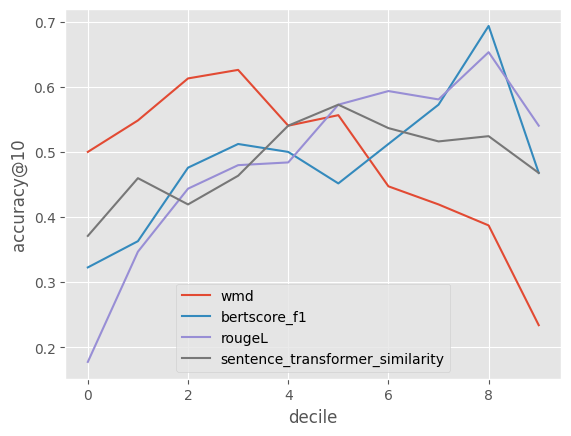

In [215]:
ir_vs_generation_quantiles_df[generation_metric_names].plot()
plt.ylabel("accuracy@10")

In [216]:
ir_vs_generation_quantiles_df[[col for col in ir_vs_generation_quantiles_df.columns if "count" in col]]

,wmd_count,bertscore_f1_count,rougeL_count,sentence_transformer_similarity_count
decile,,,,
0,62,40,22,46
1,68,45,43,57
2,76,59,55,52
3,77,63,59,57
4,67,62,60,67
5,69,56,71,71
6,55,63,73,66
7,52,71,72,64
8,48,86,81,65


In [217]:
import statsmodels.stats.proportion as sm_proportion

In [221]:
for col in ir_vs_generation_quantiles_df.columns:
    if "count" in col:
        print(col)
        (chi2, p, arr) = sm_proportion.proportions_chisquare(ir_vs_generation_quantiles_df[col], ir_vs_generation_quantiles_df[col].sum())
        print(chi2, p)

wmd_count
35.675327068361895 4.526494754469155e-05
bertscore_f1_count
26.978072599963145 0.0014104969262160143
rougeL_count
49.421411461212465 1.383597830583979e-07
sentence_transformer_similarity_count
9.73097475585038 0.37270018901411106


## Logistic regression: predict accuracy given generation metrics

In [186]:
import statsmodels.api as sm 
from sklearn import linear_model, ensemble
import scikitplot

In [159]:
X = metric_comparison_df[generation_metric_names]
y = metric_comparison_df["accuracy@10"]

In [160]:
log_reg = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.669118
         Iterations 5


In [181]:
lreg = linear_model.LogisticRegression()
lreg.fit(X, y)

LogisticRegression()

In [196]:
rf = ensemble.RandomForestClassifier(n_estimators=10, max_depth=10)
rf.fit(X,y)

RandomForestClassifier(max_depth=10, n_estimators=10)

/home/kuba/.cache/pypoetry/virtualenvs/github-search-hM2r__Rf-py3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=FutureWarning)


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

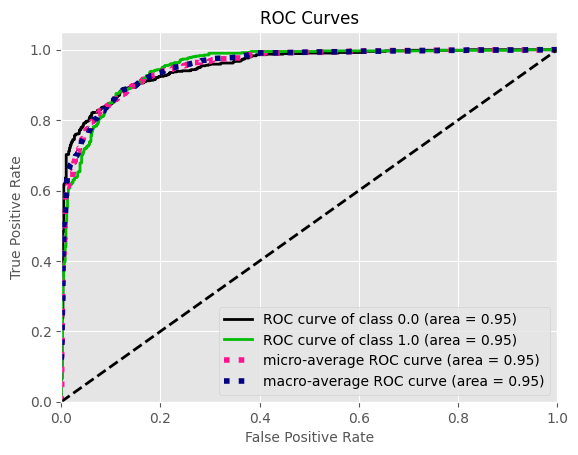

In [197]:
scikitplot.plotters.plot_roc_curve(y, rf.predict_proba(X))

In [55]:
from dowhy import CausalModel
import dowhy.datasets

# Load some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True)

## Selecting queries with highest average generation metrics


### RougeL

In [46]:

top_rouge_query_metrics_df = select_extremal_queries_by_metric(per_query_metrics_df, "rougeL")

complement_mannwhitney(top_rouge_query_metrics_df, per_query_metrics_df, "hits@10")


MannwhitneyuResult(statistic=43598.5, pvalue=3.7437584839985303e-13)

,accuracy@10,hits@10,MRR@10
count,124.000000,124.000000,124.000000
mean,0.177419,0.443548,0.090202
std,0.383573,1.231711,0.244404
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,9.000000,1.000000


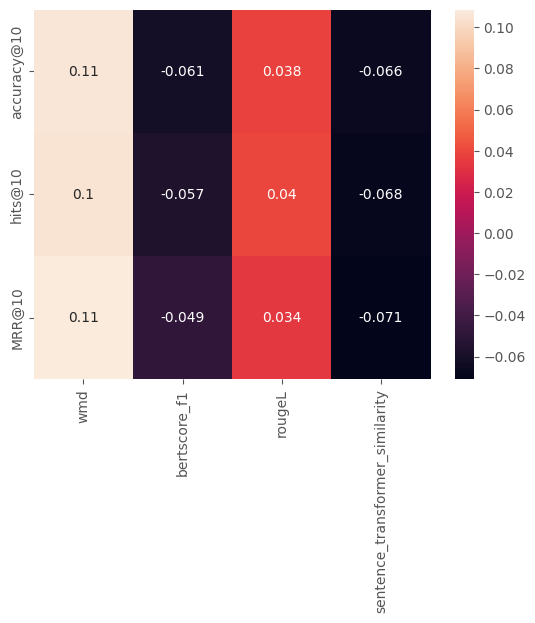

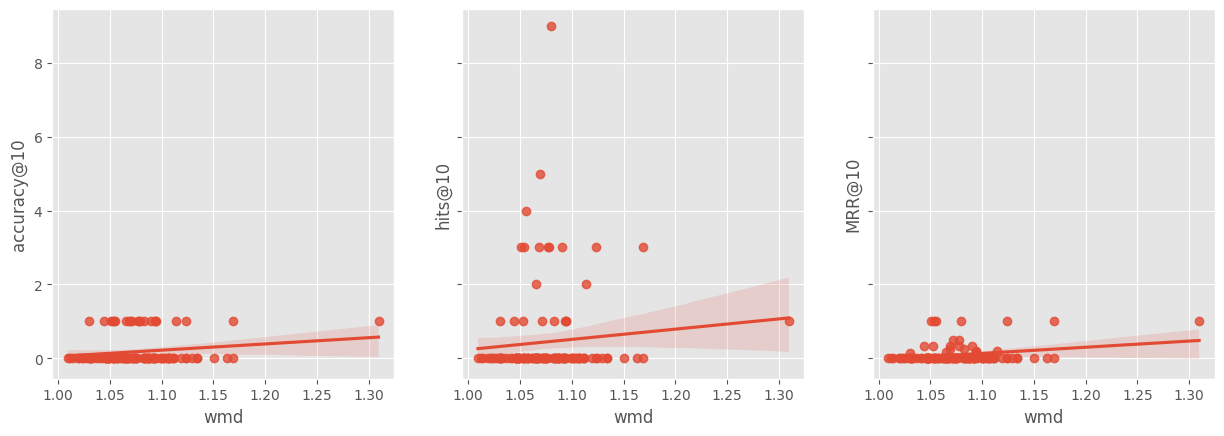

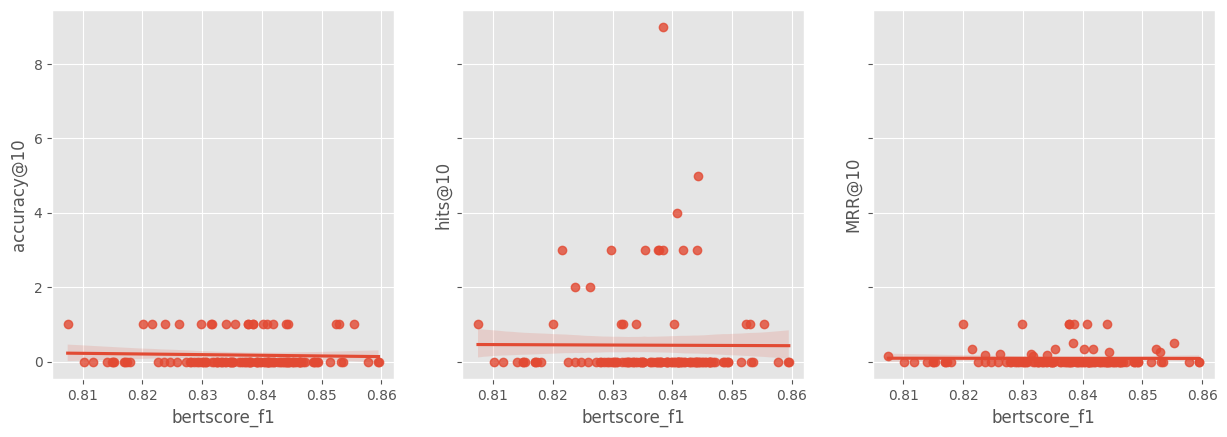

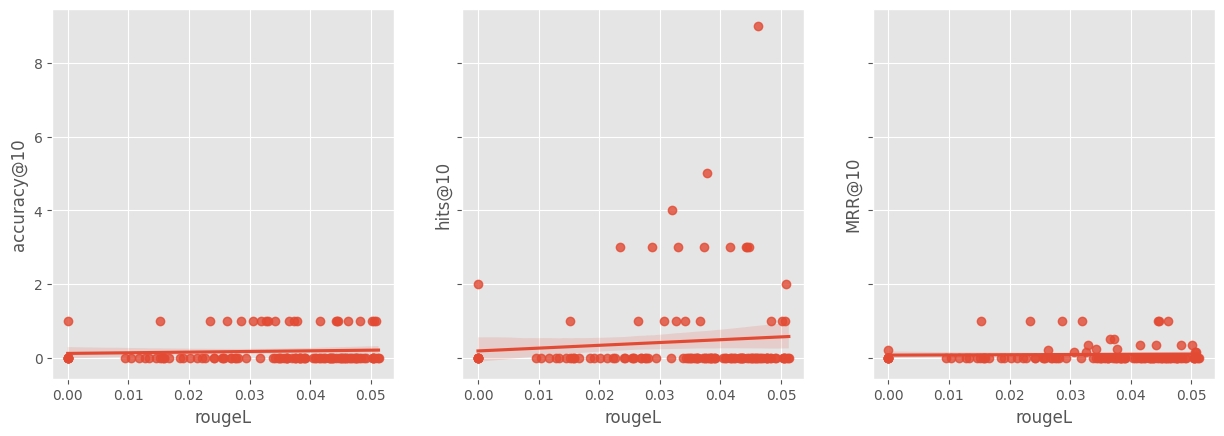

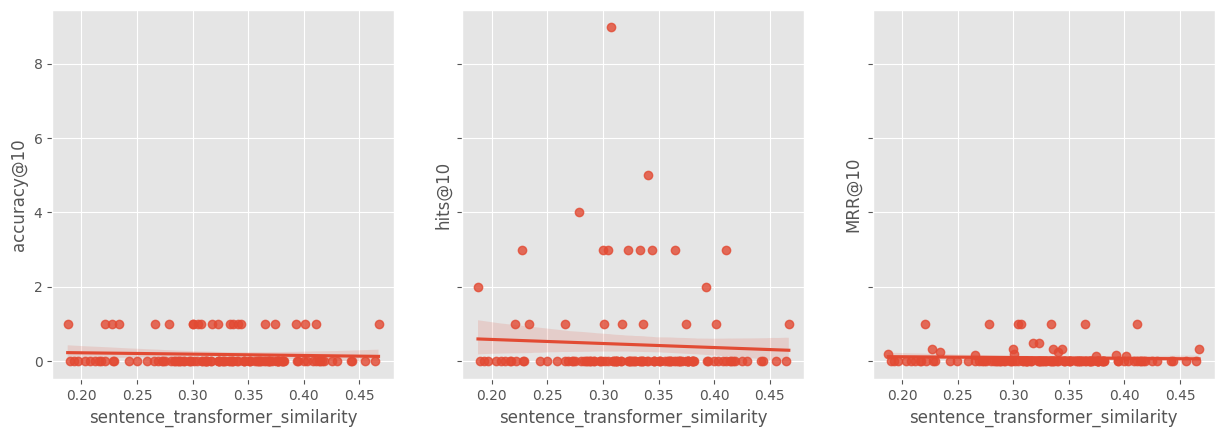

In [47]:
sns.heatmap(get_corr_df(top_rouge_query_metrics_df, ir_metric_names, generation_metric_names), annot=True)
#plt.savefig("../results/
show_pairplots(top_rouge_query_metrics_df, generation_metric_names, ir_metric_names)
top_rouge_query_metrics_df[ir_metric_names].describe().round(2).to_csv("../results/top_rouge_query_metrics.csv")
top_rouge_query_metrics_df[ir_metric_names].describe()


## Word mover's distance

In [48]:
top_wmd_query_metrics_df = select_extremal_queries_by_metric(per_query_metrics_df, "wmd", 0.9, bottom=False)

complement_mannwhitney(top_wmd_query_metrics_df, per_query_metrics_df, "hits@10")

MannwhitneyuResult(statistic=48660.0, pvalue=5.85575580683278e-09)

,accuracy@10,hits@10,MRR@10
count,124.000000,124.000000,124.000000
mean,0.233871,0.717742,0.126952
std,0.425008,1.694374,0.285361
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,9.000000,1.000000


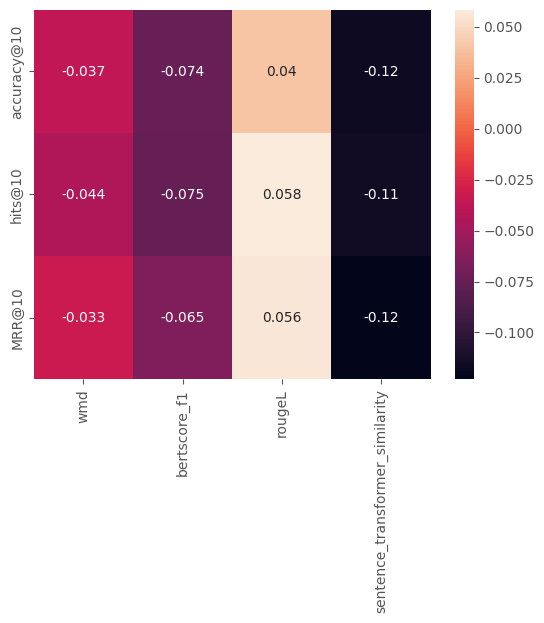

In [49]:
sns.heatmap(get_corr_df(top_wmd_query_metrics_df, ir_metric_names, generation_metric_names), annot=True)
#show_pairplots(top_bertscore_query_metrics_df, generation_metric_names, ir_metric_names)
top_wmd_query_metrics_df[ir_metric_names].describe().round(2).to_csv("../results/top_wmd_query_metrics.csv")
top_wmd_query_metrics_df[ir_metric_names].describe()

## Bertscore F1

In [50]:
top_bertscore_query_metrics_df = select_extremal_queries_by_metric(per_query_metrics_df, "bertscore_f1")

complement_mannwhitney(top_bertscore_query_metrics_df, per_query_metrics_df, "hits@10")

MannwhitneyuResult(statistic=55299.0, pvalue=8.594564748230904e-05)

,accuracy@10,hits@10,MRR@10
count,124.000000,124.000000,124.000000
mean,0.322581,1.000000,0.163726
std,0.469360,1.891358,0.319340
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.167000
max,1.000000,9.000000,1.000000


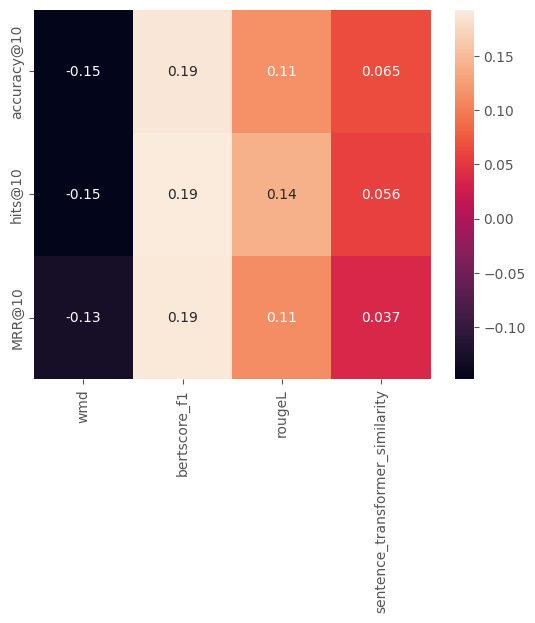

In [51]:
sns.heatmap(get_corr_df(top_bertscore_query_metrics_df, ir_metric_names, generation_metric_names), annot=True)
#show_pairplots(top_bertscore_query_metrics_df, generation_metric_names, ir_metric_names)
top_bertscore_query_metrics_df[ir_metric_names].describe().round(2).to_csv("../results/top_bertscore_query_metrics.csv")
top_bertscore_query_metrics_df[ir_metric_names].describe()

## Sentence transformer similarity

In [52]:
top_st_query_metrics_df = select_extremal_queries_by_metric(per_query_metrics_df, "sentence_transformer_similarity")

complement_mannwhitney(top_st_query_metrics_df, per_query_metrics_df, "hits@10")

MannwhitneyuResult(statistic=58825.5, pvalue=0.0034854830325830926)

,accuracy@10,hits@10,MRR@10
count,124.000000,124.000000,124.000000
mean,0.370968,1.161290,0.229863
std,0.485024,2.057653,0.373200
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,2.000000,0.333000
max,1.000000,10.000000,1.000000


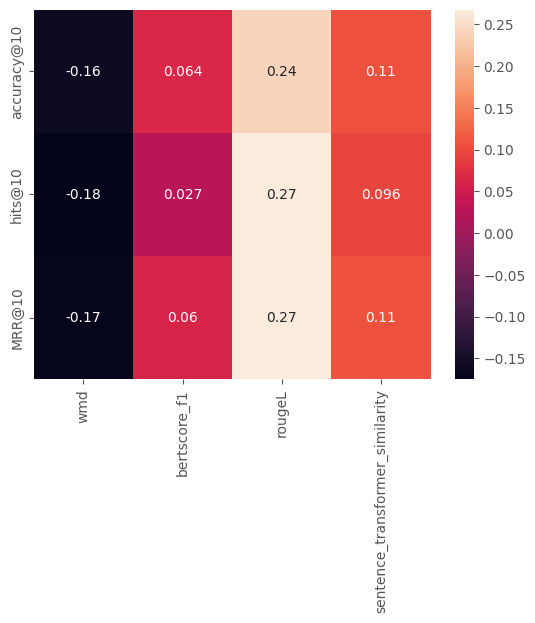

In [53]:
sns.heatmap(get_corr_df(top_st_query_metrics_df, ir_metric_names, generation_metric_names), annot=True)
#show_pairplots(top_bertscore_query_metrics_df, generation_metric_names, ir_metric_names)
top_st_query_metrics_df[ir_metric_names].describe().round(2).to_csv("../results/top_sentence_transformer_query_metrics.csv")
top_st_query_metrics_df[ir_metric_names].describe()

## Tests

In [54]:
mann_whitney_test_results = [
    {"metric": metric, "pvalue": complement_mannwhitney(df, per_query_metrics_df, "hits@10").pvalue}
    for (metric, df) in zip(["wmd", "rougeL", "sentence_transformer_similarity", "bertscore_f1"], [top_wmd_query_metrics_df, top_rouge_query_metrics_df, top_st_query_metrics_df, top_bertscore_query_metrics_df])
]

In [ ]:
mann_whitney_test_results

In [ ]:
## Selecting queries with highest average generation metrics

pd.DataFrame.from_records(mann_whitney_test_results, index="metric").to_csv("../results/utest_pvalues.csv")
### RougeL

In [ ]:
tasks_metrics_results = all_experiments_metrics_results[2]
tasks_metrics_results.ir_config.column_config

In [ ]:
tasks_per_query_metrics_df = get_per_query_metrics_df(tasks_metrics_results)[ir_metric_names]
tasks_per_query_metrics_df.describe().round(2).to_csv("../results/generated_tasks_per_query_ir_metrics.csv")
tasks_per_query_metrics_df.describe()

In [ ]:
wilcoxon(tasks_per_query_metrics_df["hits@10"], per_query_metrics_df["hits@10"]).pvalue

In [ ]:
dependencies_metrics_results = all_experiments_metrics_results[1]
dependencies_metrics_results.ir_config.column_config
dependencies_per_query_metrics_df = get_per_query_metrics_df(dependencies_metrics_results)[ir_metric_names]
dependencies_per_query_metrics_df.describe().round(2).to_csv("../results/dependencies_per_query_ir_metrics.csv")

dependencies_per_query_metrics_df[ir_metric_names].describe()

In [ ]:
wilcoxon(dependencies_per_query_metrics_df["hits@10"], per_query_metrics_df["hits@10"]).pvalue

In [ ]:
wilcoxon_test_results = [
    {"features": features, "pvalue": wilcoxon(df["hits@10"], per_query_metrics_df["hits@10"]).pvalue}
    for (features, df) in zip(["only dependency signatures", "only repository signatures"], [dependencies_per_query_metrics_df, tasks_per_query_metrics_df])
]

wilcoxon_test_results_df = pd.DataFrame.from_records(wilcoxon_test_results, index="features")

In [ ]:
wilcoxon_test_results_df.to_csv("../results/wilcoxon_pvalues.csv")

In [ ]:
mannwhitneyu(top_wmd_query_metrics_df["hits@10"], get_complement_metric_values(top_wmd_query_metrics_df, per_query_metrics_df, "hits@10"))

In [ ]:
wilcoxon_test_results_df.round(decimals=4)

In [ ]:
from seaborn_qqplot import pplot

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

In [ ]:
def get_quantiles(srs, n=100):
    qs = np.linspace(0, 1, n)
    return srs.quantile(list(qs))

In [ ]:
cdf = ECDF(top_wmd_query_metrics_df["hits@10"])

## QQPlots

In [ ]:
from statsmodels.graphics.gofplots import qqplot_2samples

qqplot_2samples(top_wmd_query_metrics_df["hits@10"], per_query_metrics_df["hits@10"]);

In [ ]:
qqplot_2samples(top_rouge_query_metrics_df["hits@10"], per_query_metrics_df["hits@10"]);

In [ ]:
scipy.stats.kstest(top_wmd_query_metrics_df["hits@10"], get_df_complement(top_wmd_query_metrics_df, per_query_metrics_df)["hits@10"])

In [ ]:
scipy.stats.kstest(top_rouge_query_metrics_df["hits@10"], get_df_complement(top_rouge_query_metrics_df, per_query_metrics_df)["hits@10"])

In [ ]:
plt.plot(.sort_values(), )

In [ ]:
import statsmodels.api as sm


In [ ]:

def get_df_complement(df_subset, df):
    return df[~pd.Series(df.index).isin(df_subset.index).values]